In [4]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import pandas as pd
import re

# The Project

The idea here is to simulate the FIFA 2022 World Cup games with machine learning, in order to predict the competition's winner. The project uses two datasets: [International football results from 1872 to 2022](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017) and [FIFA World Ranking 1992-2022](https://www.kaggle.com/datasets/cashncarry/fifaworldranking)

I've used the same logic that was used in the [Soccer World Cup 2018 Winner
](https://www.kaggle.com/code/agostontorok/soccer-world-cup-2018-winner) notebook, that models the problem as binary classification one. I used this to make more easy to analyze model's results, so the model predicts between win from home team and draw/win from away team. Then, to remove the advantage of away team, I predicted the results changing teams from away and home (because there is not home advantage in World Cup), and used as probabilities the mean of the two predictions. 

# Data Preparation

Here, I'll prepare the data to apply feature engineering methods that will create the database in order to apply Machine Learning algorithms.

In [6]:
df =  pd.read_csv("results.csv")

In [7]:
df["date"] = pd.to_datetime(df["date"])

In [8]:
df.isna().sum()

date           0
home_team      0
away_team      0
home_score    48
away_score    48
tournament     0
city           0
country        0
neutral        0
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.dtypes

date          datetime64[ns]
home_team             object
away_team             object
home_score           float64
away_score           float64
tournament            object
city                  object
country               object
neutral                 bool
dtype: object

The dataset used will be the FIFA Games between 2018, from after the 2018 World Cup to the last games before the 2022 World Cup. The idea is to analyze just the games played at the preparation and classification to WC.

In [11]:
df.sort_values("date").tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
44083,2022-11-16,Andorra,Austria,0.0,1.0,Friendly,Malaga,Spain,True
44082,2022-11-16,Algeria,Mali,1.0,1.0,Friendly,Oran,Algeria,False
44081,2022-11-16,Albania,Italy,1.0,3.0,Friendly,Tirana,Albania,False
44091,2022-11-16,Mexico,Sweden,1.0,2.0,Friendly,Girona,Spain,True
44103,2022-11-16,Latvia,Estonia,1.0,1.0,Baltic Cup,Riga,Latvia,False


In [12]:
df = df[(df["date"] >= "2018-8-1")].reset_index(drop=True)

In [13]:
df.sort_values("date").tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
3784,2022-11-16,Andorra,Austria,0.0,1.0,Friendly,Malaga,Spain,True
3783,2022-11-16,Algeria,Mali,1.0,1.0,Friendly,Oran,Algeria,False
3782,2022-11-16,Albania,Italy,1.0,3.0,Friendly,Tirana,Albania,False
3792,2022-11-16,Mexico,Sweden,1.0,2.0,Friendly,Girona,Spain,True
3804,2022-11-16,Latvia,Estonia,1.0,1.0,Baltic Cup,Riga,Latvia,False


In [14]:
df.home_team.value_counts()

United States               45
Mexico                      42
Qatar                       40
Bahrain                     38
Japan                       37
                            ..
Tonga                        1
Bhutan                       1
Alderney                     1
Saint Helena                 1
Northern Mariana Islands     1
Name: home_team, Length: 247, dtype: int64

In [16]:
rank = pd.read_csv("fifa_ranking-2022-10-06.csv")

In [17]:
rank["rank_date"] = pd.to_datetime(rank["rank_date"])
rank = rank[(rank["rank_date"] >= "2018-8-1")].reset_index(drop=True)


Some teams in the World Cup have different names in the ranking's dataset. So, it's needed to adjust. 

In [18]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")

The merge is made in order to get a dataset FIFA games and its rankings.

In [19]:
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

In [20]:
df_wc_ranked = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

In [21]:
df_wc_ranked[(df_wc_ranked.home_team == "Brazil") | (df_wc_ranked.away_team == "Brazil")].tail(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
2528,2021-11-11,Brazil,Colombia,1.0,0.0,FIFA World Cup qualification,São Paulo,Brazil,False,1820.36,1811.73,2.0,0.0,1618.76,1618.40,16.0,0.0
2629,2021-11-16,Argentina,Brazil,0.0,0.0,FIFA World Cup qualification,San Juan,Argentina,False,1738.79,1725.31,6.0,0.0,1820.36,1811.73,2.0,0.0
2737,2022-01-27,Ecuador,Brazil,1.0,1.0,FIFA World Cup qualification,Quito,Ecuador,False,1448.27,1448.74,46.0,0.0,1826.35,1826.35,2.0,0.0
2770,2022-02-01,Brazil,Paraguay,4.0,0.0,FIFA World Cup qualification,Belo Horizonte,Brazil,False,1826.35,1826.35,2.0,0.0,1454.52,1454.52,43.0,0.0
2811,2022-03-24,Brazil,Chile,4.0,0.0,FIFA World Cup qualification,Rio de Janeiro,Brazil,False,1823.42,1826.35,2.0,0.0,1543.16,1543.42,26.0,2.0
2894,2022-03-29,Bolivia,Brazil,0.0,4.0,FIFA World Cup qualification,La Paz,Bolivia,False,1308.12,1324.21,76.0,-1.0,1823.42,1826.35,2.0,0.0
2986,2022-06-02,South Korea,Brazil,1.0,5.0,Friendly,Seoul,South Korea,False,1519.54,1522.85,29.0,0.0,1832.69,1823.42,1.0,-1.0
3054,2022-06-06,Japan,Brazil,0.0,1.0,Friendly,Tokyo,Japan,False,1553.44,1549.82,23.0,0.0,1832.69,1823.42,1.0,-1.0
3231,2022-09-23,Brazil,Ghana,3.0,0.0,Friendly,Le Havre,France,True,1837.56,1837.56,1.0,0.0,1393.47,1389.68,60.0,0.0
3300,2022-09-27,Brazil,Tunisia,5.0,1.0,Friendly,Paris,France,True,1837.56,1837.56,1.0,0.0,1507.86,1507.86,30.0,0.0


Now, we have the data ready to create features based on the games' results and FIFA rankings.

# Features Engineering

The idea here is to create possible features that have impact on predicting football games. By intuition, we say that features that impact could be:

- Past game points made
- Past goals scored and suffered
- The importance of game (friendly or not)
- Rank of the teams 
- Rank increasement of the teams
- Goals made and suffered by ranking faced

So, the first thing to do is create the feature that says which team won and how much points they made at game. 

In [22]:
df = df_wc_ranked

In [23]:
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

In [24]:
df[["result", "home_team_points", "away_team_points"]] = results

The game points are 3 for win, 1 for draw and 0 for lose and are different than the FIFA rank points that are already in the database. Also, it's supposed that FIFA Rank points and FIFA Ranking of the same team are negative correlated, and we should use only one of them to create new features. This supposition is checked below:

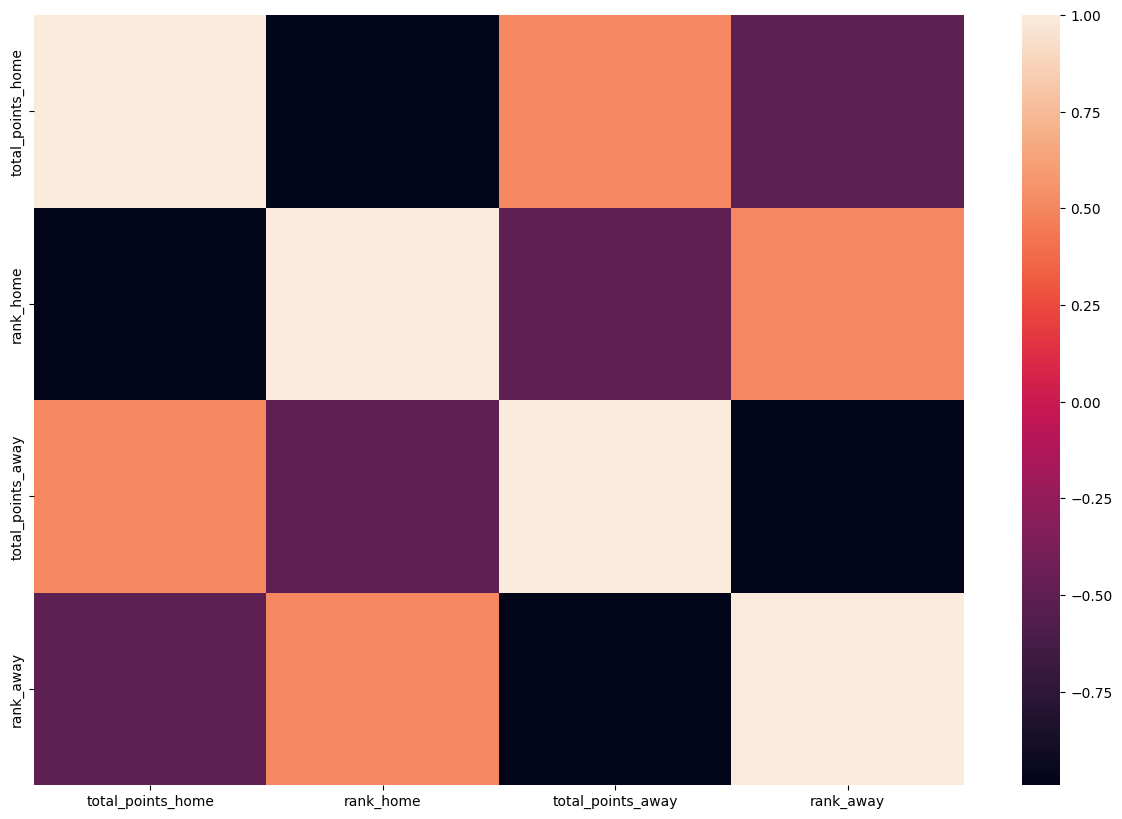

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(df[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr())
plt.show()

Now, we create columns that will help in the creation of the features: ranking difference, points won at the game vs. team faced rank, and goals difference in the game. All features that are not differences should be created for the two teams (away and home).

In [27]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

In order to create the features, I'll separate the dataset in home team's and away team's dataset, unify them and calculate the past game values. After that, I'll separate again and merge them, retrieving the original dataset. This proccess optimizes the creation of the features.

In [28]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

In [29]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [30]:
team_stats = home_team.append(away_team)#.sort_values("date")

C:\Users\user\AppData\Local\Temp\ipykernel_7836\275322566.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  team_stats = home_team.append(away_team)#.sort_values("date")


In [31]:
#this column will be used to calculate features for simulation
team_stats_raw = team_stats.copy()

Now, we have a database ready to create predictive features. They will be:

- Mean goals of the team in World Cup Cycle.
- Mean goals of the team in last 5 games.
- Mean goals suffered of the team in World Cup Cycle.
- Mean goals suffered of the team in last 5 games.
- Mean FIFA Rank that team faced in World Cup Cycle.
- Mean FIFA Rank that team faced in last 5 games.
- FIFA Points won at the cycle.
- FIFA Points won in last 5 games.
- Mean game points at the Cycle.
- Mean game points at last 5 games.
- Mean game points by rank faced at the Cycle.
- Mean game points by rank faced at last 5 games.

In [32]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

In [33]:
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [34]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

The new columns:

In [35]:
home_team_stats.columns[-12:]

Index(['goals_mean', 'goals_mean_l5', 'goals_suf_mean', 'goals_suf_mean_l5',
       'rank_mean', 'rank_mean_l5', 'points_mean', 'points_mean_l5',
       'game_points_mean', 'game_points_mean_l5', 'game_points_rank_mean',
       'game_points_rank_mean_l5'],
      dtype='object')

In [36]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

In [37]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

In order to unify the database, is needed to add home_ and away_ suffix for each column. After that, the data is ready to be merged.

In [38]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [39]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [40]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

Now, to quantify game importance, is created a column that finds competition of the game.

In [41]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

In [42]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [43]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

And, after that, we select only columns that will help in Features' analysis.

In [44]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]

base_df.tail()

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1
3331,2022-09-27,Norway,Serbia,36.0,25.0,0.0,2.0,1,11.0,0.0,...,1.833333,2.0,0.041984,0.090235,1.866667,2.0,0.053327,0.073887,1,0
3332,2022-09-27,Sweden,Slovenia,20.0,65.0,1.0,1.0,2,-45.0,0.0,...,1.607843,0.6,0.048520,0.009231,1.404762,1.0,0.026035,0.029545,1,0
3333,2022-09-27,Kosovo,Cyprus,106.0,108.0,5.0,1.0,0,-2.0,0.0,...,1.326087,1.2,0.018478,0.016825,0.767442,1.0,0.009687,0.019652,1,0
3334,2022-09-27,Greece,Northern Ireland,49.0,58.0,3.0,1.0,0,-9.0,1.0,...,1.590909,2.4,0.050090,0.028040,1.139535,1.0,0.022315,0.009470,1,0
3335,2022-09-30,Fiji,Solomon Islands,163.0,137.0,1.0,0.0,0,26.0,0.0,...,1.500000,1.4,0.009432,0.008868,1.714286,2.0,0.010013,0.012387,1,0


In [45]:
base_df.isna().sum()

date                               0
home_team                          0
away_team                          0
rank_home                          0
rank_away                          0
home_score                         0
away_score                         0
result                             0
rank_dif                           0
rank_change_home                   0
rank_change_away                   0
home_goals_mean                  101
home_goals_mean_l5               101
home_goals_suf_mean              101
home_goals_suf_mean_l5           101
home_rank_mean                   101
home_rank_mean_l5                101
home_points_mean                   0
home_points_mean_l5                0
away_goals_mean                  100
away_goals_mean_l5               100
away_goals_suf_mean              100
away_goals_suf_mean_l5           100
away_rank_mean                   100
away_rank_mean_l5                100
away_points_mean                   0
away_points_mean_l5                0
h

The games with NA are the ones who mean could not be calculated (games from the beginning of the dataset). Those will be dropped.

In [46]:
base_df_no_fg = base_df.dropna()

# Data Analysis

Now, we need to analyze all features that were created and check if they have predictive power. Also, if they don't have, we need to create some that have, like differences of home and away teams. To analyze the predictive power, I'll assign draw games as a lose of the home team and will create a binary problem. 

In [47]:
df = base_df_no_fg

In [48]:
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
df["target"] = df["result"].apply(lambda x: no_draw(x))

C:\Users\user\AppData\Local\Temp\ipykernel_7836\1906038641.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = df["result"].apply(lambda x: no_draw(x))


Analysis that will be made:

- Violin and boxplot to analyze if the features have different distributions according to the target
- Scatter plots to analyze correlations

In [49]:
data1 = df[list(df.columns[8:20].values) + ["target"]]
data2 = df[df.columns[20:]]

In [50]:
scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

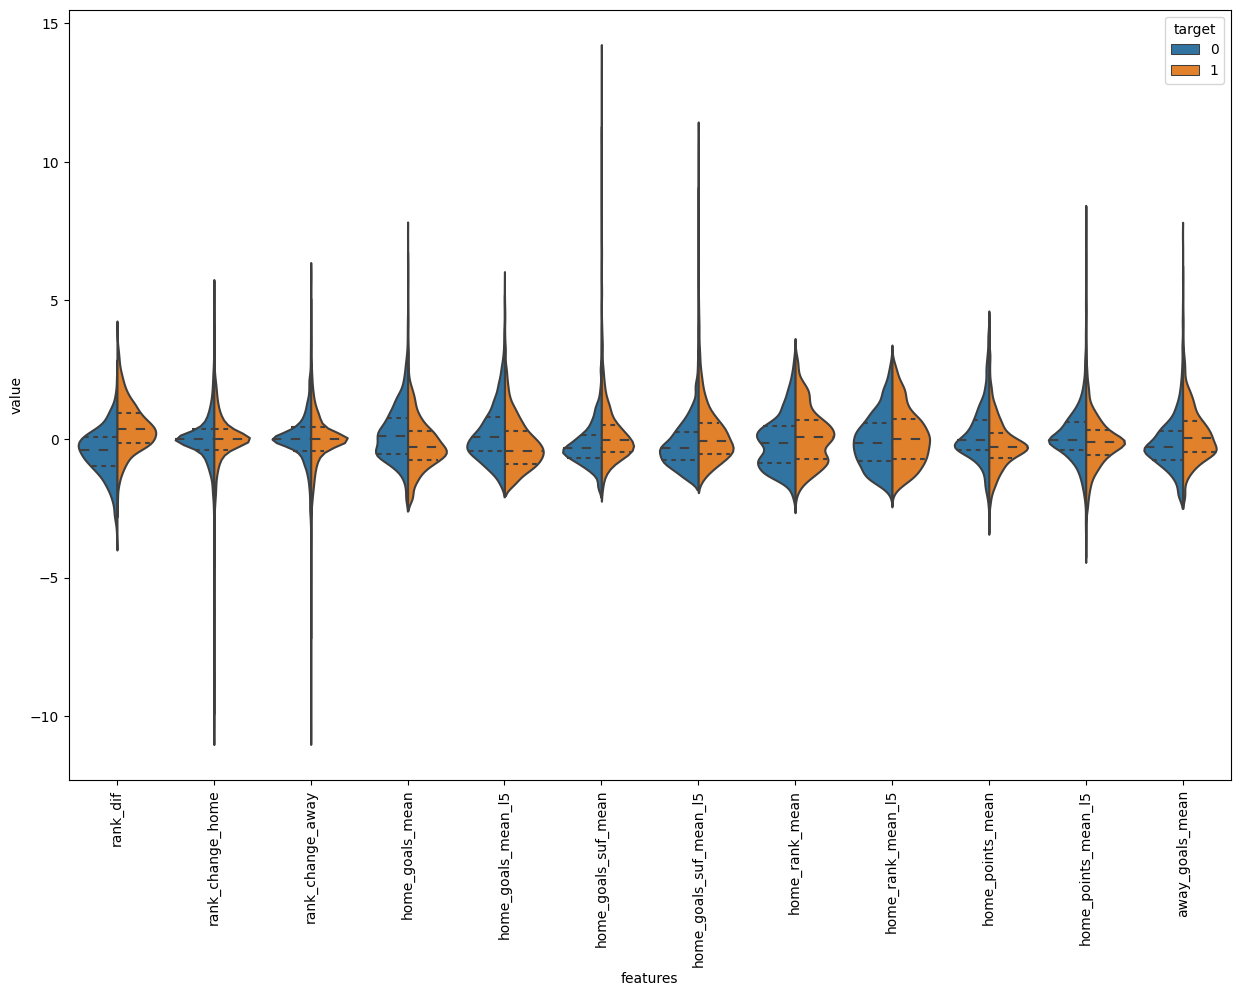

In [51]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin1,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

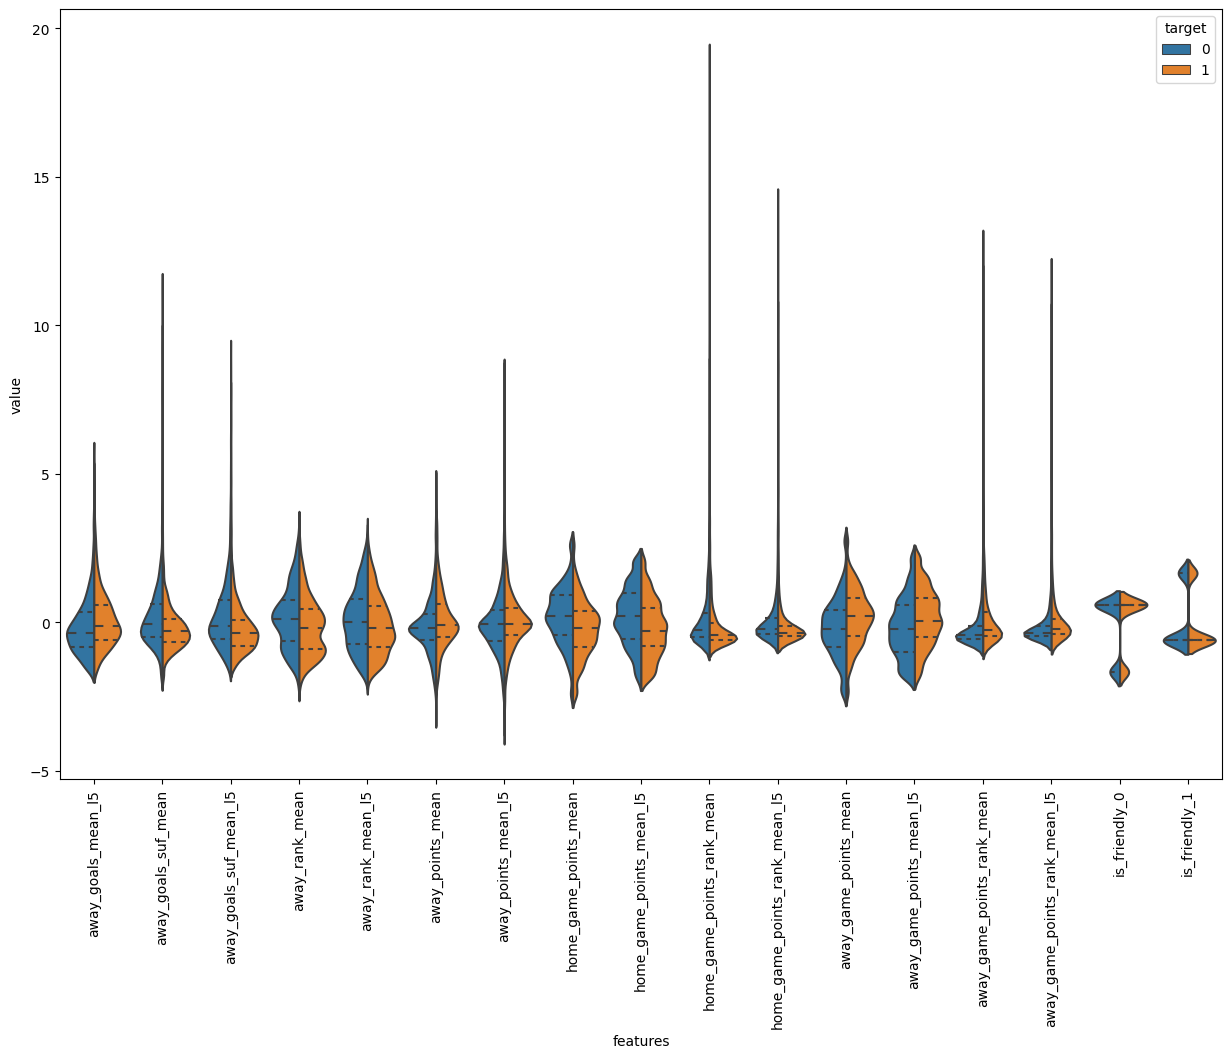

In [52]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin2,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

With the plots, we find that rank difference is the only good separator of the data. But, we can create features that get the differences between home and away team and analyze if they are good separating the data.

In [53]:
dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]

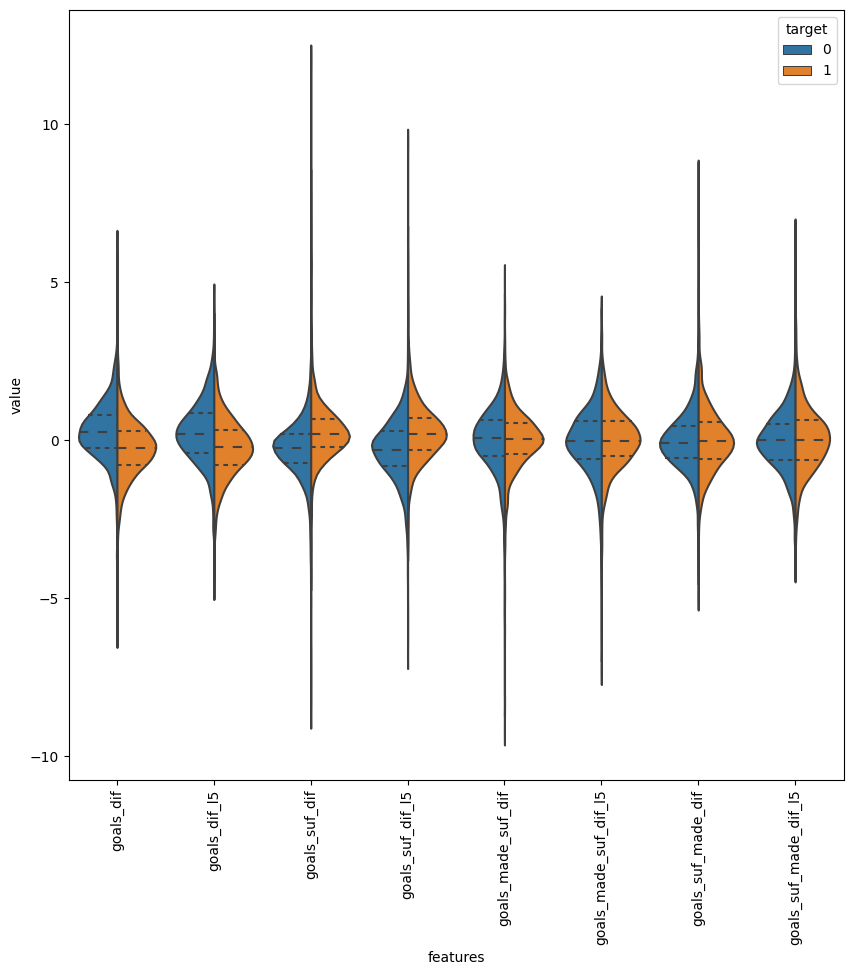

In [54]:
data_difs = dif.iloc[:, -8:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

With that plot, we see that goal differences are good separator, and goals suffered difference too. Differences between goals made and goals suffered of the teams are not very good separators.

Now, we have 5 features:

- rank_dif
- goals_dif
- goals_dif_l5
- goals_suf_dif
- goals_suf_dif_l5

We can create other features, like differences of points made, differences of points made by rank faced and differences of rank faced.

In [55]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]

In [56]:
dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]

Also, we can calculate goals made and suffered by rank, and check this difference.

In [57]:
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])

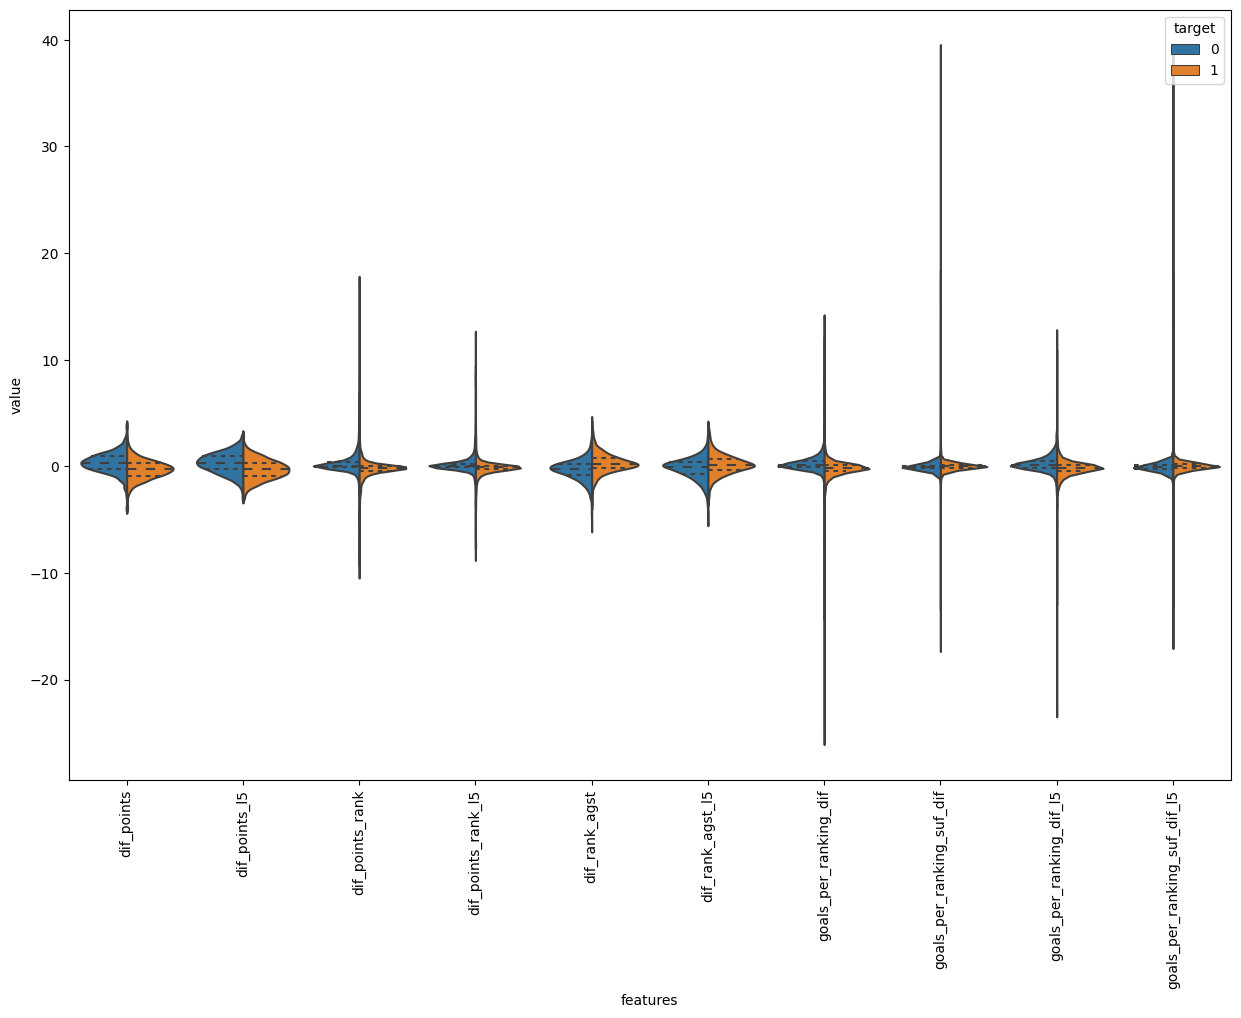

In [58]:
data_difs = dif.iloc[:, -10:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Due to the low values, the violin plot was not a good choice to analyze if features are really separating the data in this case. We will see then the boxplot:

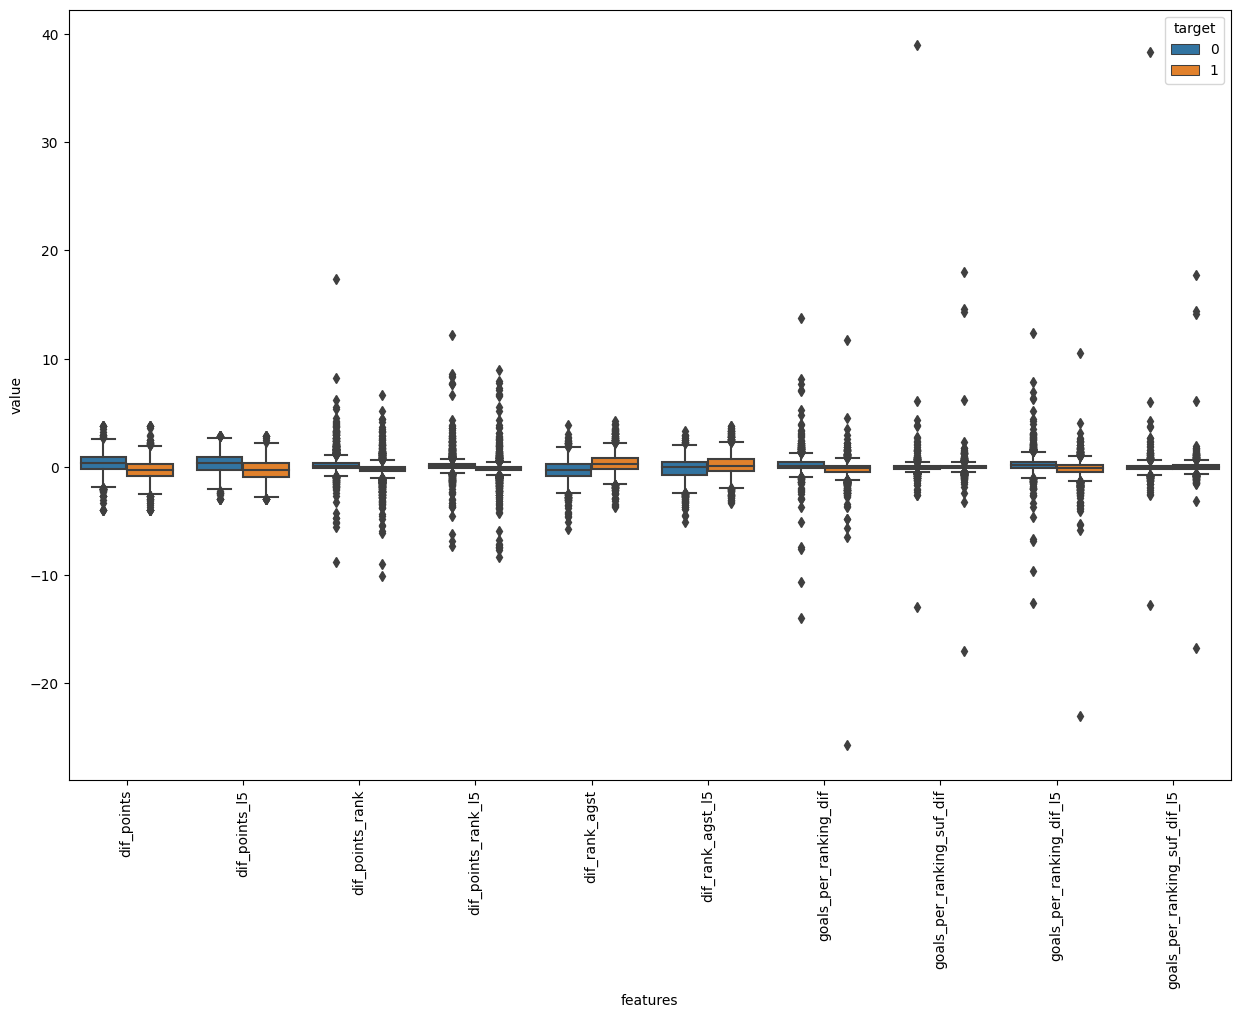

In [59]:
plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="target", data=violin)
plt.xticks(rotation=90)
plt.show()

Difference of points (full and last 5 games), difference of points by ranking faced (full and last 5 games) and difference of rank faced (full and last 5 games) are good features. Also, some of the generated features have very similar distributions which will be analyzed using scatterplots.

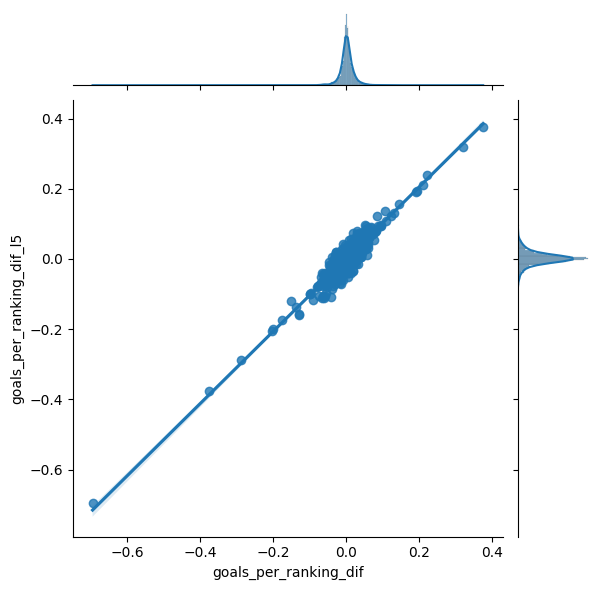

In [60]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_dif', y = 'goals_per_ranking_dif_l5', kind="reg")
plt.show()

Goals difference by ranking faced and its last 5 games version has very similar distributions. So, we will use only the full version (goals_per_ranking_dif).

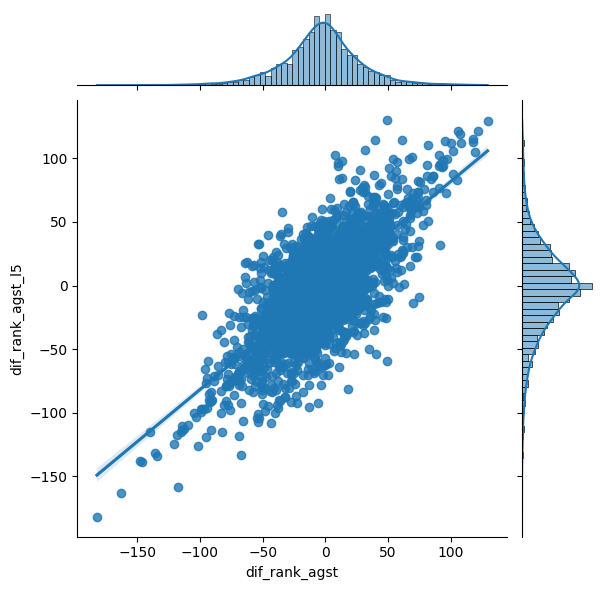

In [61]:
sns.jointplot(data = data_difs, x = 'dif_rank_agst', y = 'dif_rank_agst_l5', kind="reg")
plt.show()

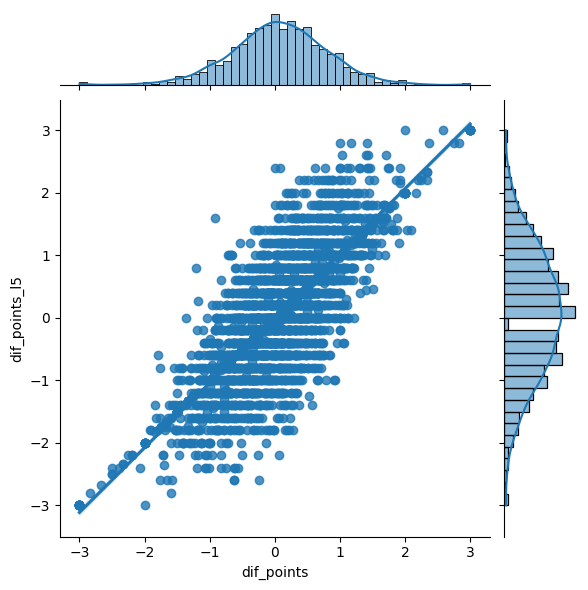

In [62]:
sns.jointplot(data = data_difs, x = 'dif_points', y = 'dif_points_l5', kind="reg")
plt.show()

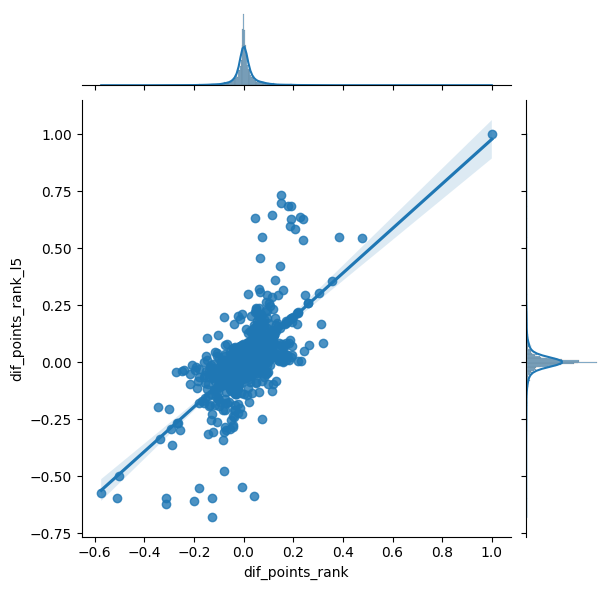

In [63]:
sns.jointplot(data = data_difs, x = 'dif_points_rank', y = 'dif_points_rank_l5', kind="reg")
plt.show()

For the differences of rank faced, game points by rank faced and mean game points by rank faced, the two versions (full and 5 games) are not so similar. So, we will use both.

Based on that, final features are:


- rank_dif
- goals_dif
- goals_dif_l5
- goals_suf_dif
- goals_suf_dif_l5
- dif_rank_agst
- dif_rank_agst_l5
- goals_per_ranking_dif
- dif_points_rank
- dif_points_rank_l5
- is_friendly

In [64]:
def create_db(df):
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df

In [65]:
model_db = create_db(df)

In [66]:
model_db

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_1
4,Barbados,Cuba,1,-21.0,2.000000,2.0,1.000000,1.0,0.037037,-92.000000,-92.0,0.018519,0.018519,0,1
6,Barbados,Cuba,1,-21.0,1.000000,1.0,0.500000,0.5,0.008511,-35.500000,-35.5,0.008897,0.008897,0,1
31,Mongolia,Guam,1,-4.0,4.000000,4.0,-1.000000,-1.0,0.021622,0.000000,0.0,0.016216,0.016216,1,0
32,Nepal,Bhutan,0,-22.0,1.000000,1.0,0.000000,0.0,0.004975,7.000000,7.0,0.000000,0.000000,1,0
33,Bangladesh,Pakistan,0,-7.0,-1.000000,-1.0,-0.500000,-0.5,-0.007200,30.500000,30.5,-0.010437,-0.010437,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3331,Norway,Serbia,1,11.0,-0.038095,-0.8,-0.230159,0.0,-0.005282,9.014286,-3.4,-0.011343,0.016348,1,0
3332,Sweden,Slovenia,1,-45.0,0.030812,0.2,0.137255,0.2,0.009459,-25.102241,10.2,0.022485,-0.020314,1,0
3333,Kosovo,Cyprus,0,-2.0,0.667341,0.6,-0.463094,0.0,0.007625,7.037917,1.6,0.008791,-0.002827,1,0
3334,Greece,Northern Ireland,0,-9.0,0.067653,0.2,-0.369979,-1.2,-0.002915,16.024841,0.6,0.027775,0.018570,1,0


# The model

Now that we have a database ready and with columns with predictive power, we can start our modelling. 

Two models will be tested: Random Forest and Gradient Boosting. The selected will be the one with best recall.

In [67]:
X = model_db.iloc[:, 3:]
y = model_db[["target"]]

In [68]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [70]:
gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10],
            "max_features":["sqrt"],
            "n_estimators":[100, 200]
         } 

gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = False)

gb_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [71]:
gb = gb_cv.best_estimator_

In [72]:
gb

GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=5,
                           random_state=5)

In [73]:
params_rf = {"max_depth": [20],
                "min_samples_split": [10],
                "max_leaf_nodes": [175],
                "min_samples_leaf": [5],
                "n_estimators": [250],
                 "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)

rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [20], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [175], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [250]},
             verbose=False)

In [74]:
rf = rf_cv.best_estimator_

In [75]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [76]:
def analyze(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")

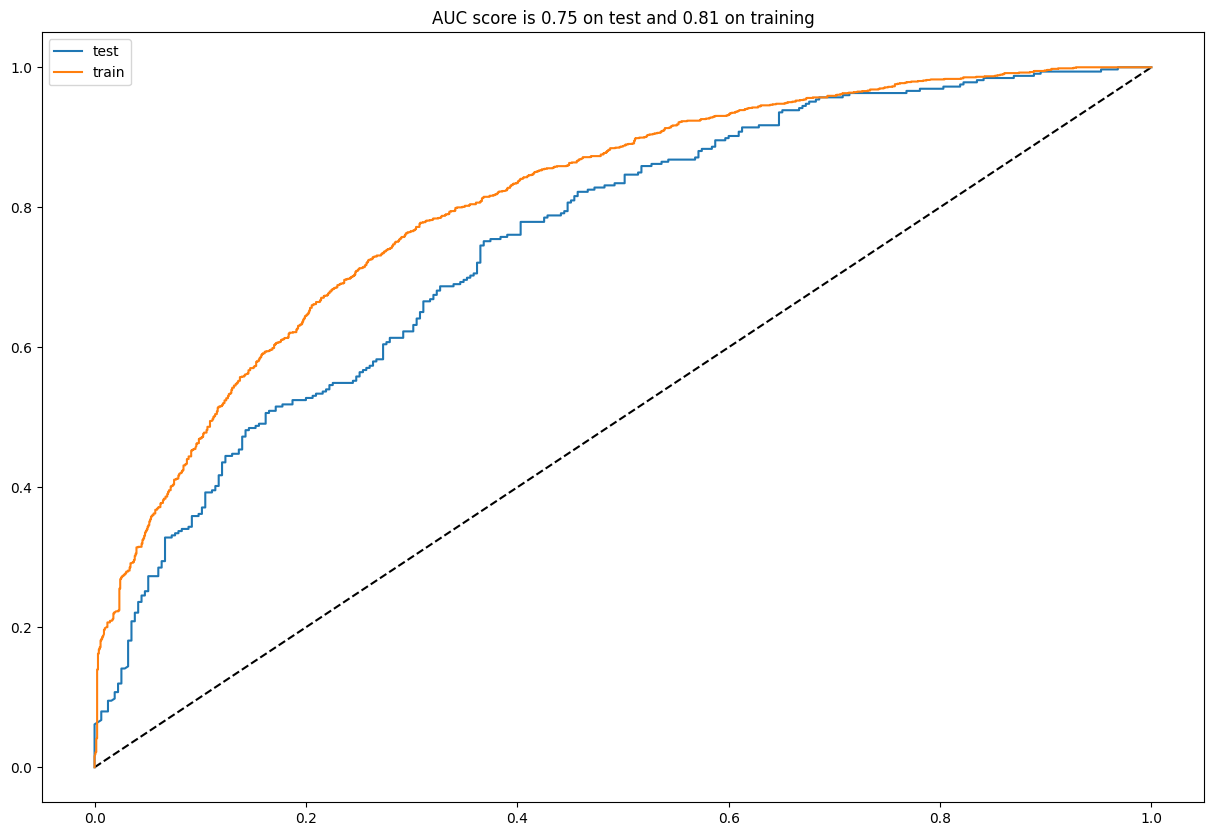

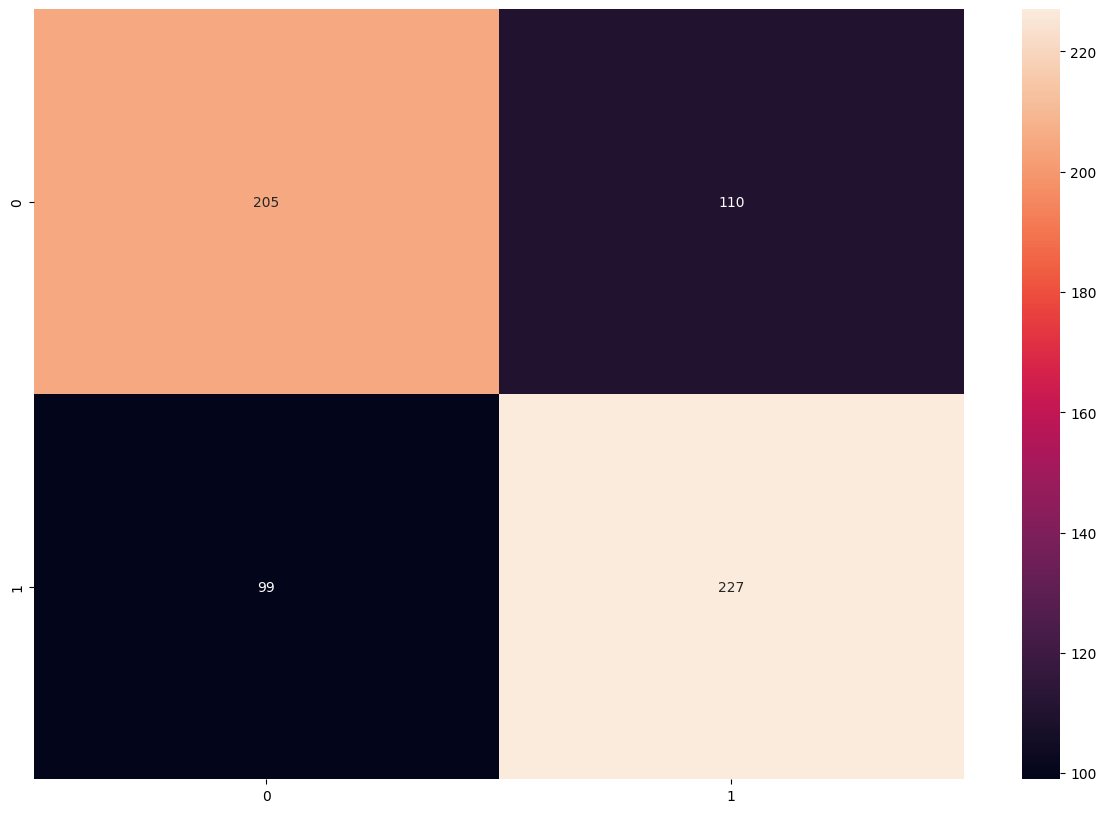

In [77]:
analyze(gb)

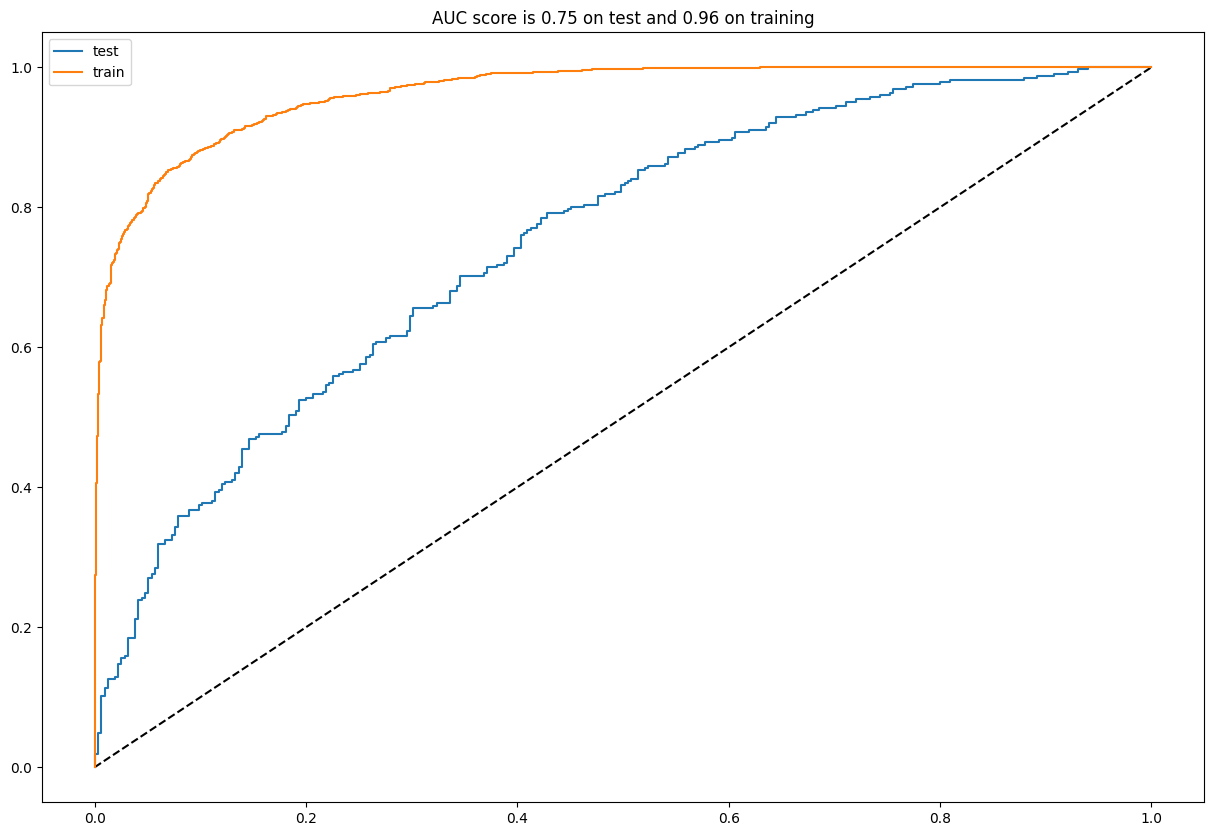

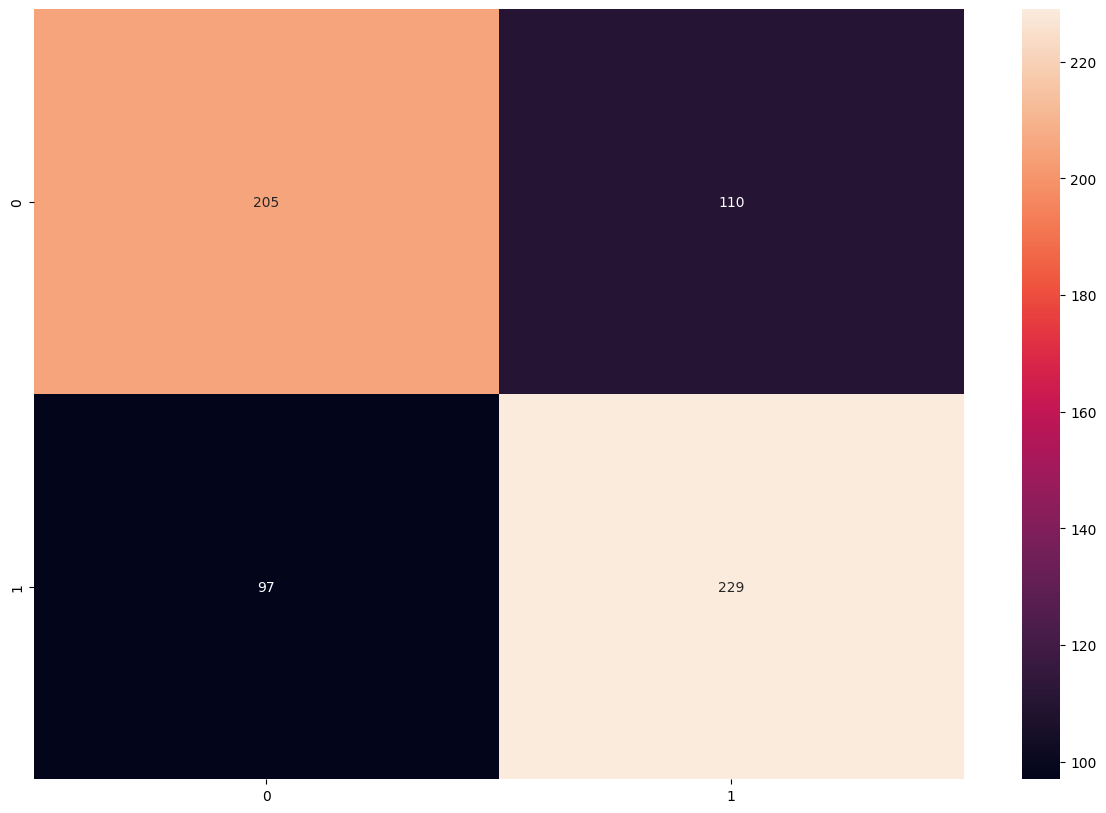

In [78]:
analyze(rf)

The Random Forest model is a little bit better but seems to underfit. So, we will use the Gradient Boosting Model.

In [79]:
from operator import itemgetter

# WC Simulation

The first thing is to create FIFA World Cup games. To do this, I'll get in the wikipedia the teams and group phase matches.

In [80]:
dfs = pd.read_html(r"https://en.wikipedia.org/wiki/2022_FIFA_World_Cup#Teams")

In [81]:
from collections.abc import Iterable

for i in range(len(dfs)):
    df = dfs[i]
    cols = list(df.columns.values)
    
    if isinstance(cols[0], Iterable):
        if any("Tie-breaking criteria" in c for c in cols):
            start_pos = i+1

        if any("Match 46" in c for c in cols):
            end_pos = i+1

In [82]:
matches = []
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
group_count = 0 

table = {}
#TABLE -> TEAM, POINTS, WIN PROBS (CRITERIO DE DESEMPATE)
table[groups[group_count]] = [[a.split(" ")[0], 0, []] for a in list(dfs[start_pos].iloc[:, 1].values)]

for i in range(start_pos+1, end_pos, 1):
    if len(dfs[i].columns) == 3:
        team_1 = dfs[i].columns.values[0]
        team_2 = dfs[i].columns.values[-1]
        
        matches.append((groups[group_count], team_1, team_2))
    else:
        group_count+=1
        table[groups[group_count]] = [[a, 0, []] for a in list(dfs[i].iloc[:, 1].values)]

In [83]:
table

{'A': [['Qatar', 0, []],
  ['Ecuador', 0, []],
  ['Senegal', 0, []],
  ['Netherlands', 0, []]],
 'B': [['England', 0, []],
  ['Iran', 0, []],
  ['United States', 0, []],
  ['Wales', 0, []]],
 'C': [['Argentina', 0, []],
  ['Saudi Arabia', 0, []],
  ['Mexico', 0, []],
  ['Poland', 0, []]],
 'D': [['France', 0, []],
  ['Australia', 0, []],
  ['Denmark', 0, []],
  ['Tunisia', 0, []]],
 'E': [['Spain', 0, []],
  ['Costa Rica', 0, []],
  ['Germany', 0, []],
  ['Japan', 0, []]],
 'F': [['Belgium', 0, []],
  ['Canada', 0, []],
  ['Morocco', 0, []],
  ['Croatia', 0, []]],
 'G': [['Brazil', 0, []],
  ['Serbia', 0, []],
  ['Switzerland', 0, []],
  ['Cameroon', 0, []]],
 'H': [['Portugal', 0, []],
  ['Ghana', 0, []],
  ['Uruguay', 0, []],
  ['South Korea', 0, []]]}

Above, we also store the team's points at the group and its probabilities of win in each game. The mean of team's wins probabilities will be used as tiebreaker when two teams have the same number of points.

In [84]:
matches[:10]

[('A', 'Qatar', 'Ecuador'),
 ('A', 'Senegal', 'Netherlands'),
 ('A', 'Qatar', 'Senegal'),
 ('A', 'Netherlands', 'Ecuador'),
 ('A', 'Ecuador', 'Senegal'),
 ('A', 'Netherlands', 'Qatar'),
 ('B', 'England', 'Iran'),
 ('B', 'United States', 'Wales'),
 ('B', 'Wales', 'Iran'),
 ('B', 'England', 'United States')]

I will use last game stats as the stats for each team involved in the game. Like, for Brazil vs Serbia, the stats of Brazil is the ones they had in the last game and for Serbia too.

In [85]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

In [86]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

Now, we are able to simulate.

Since the model simulates if team 1 will win or not win, it's needed to create some criteria to define a draw. Also, since we have not home advantage at World Cup, the idea is to predict game two times, changing team 1 and team 2. The team with the highest mean of probabilities will be assigned as winner. At the group phase, if "home team" win as team 1 and loses as team 2, or if "home team" win as team 2 and loses at team 1, there will be assigned a draw in that match.

In [87]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Winner Ecuador with 0.60 probability
Group A - Senegal vs. Netherlands: Winner Netherlands with 0.59 probability
Group A - Qatar vs. Senegal: Winner Senegal with 0.58 probability
Group A - Netherlands vs. Ecuador: Winner Netherlands with 0.66 probability
Group A - Ecuador vs. Senegal: Winner Ecuador with 0.53 probability
Group A - Netherlands vs. Qatar: Winner Netherlands with 0.69 probability


Group A advanced: 
Netherlands -------- 9
Ecuador -------- 6
Senegal -------- 3
Qatar -------- 0


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.60 probability
Group B - United States vs. Wales: Draw
Group B - Wales vs. Iran: Winner Wales with 0.54 probability
Group B - England vs. United States: Winner England with 0.58 probability
Group B - Wales vs. England: Winner England with 0.60 probability
Group B - Iran vs. United States: Winner United States with 0

The group phase predicted no surprises, or maybe the draw between Brazil and Switzerland or France and Denmark. For the playoffs phase, I'll predict and show it graphically as made [here](https://www.kaggle.com/code/agostontorok/soccer-world-cup-2018-winner). 

In [88]:
advanced = advanced_group

In [89]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [90]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Starting simulation of Round of 16
----------


Netherlands vs. United States: Netherlands advances with prob 0.55
Argentina vs. Denmark: Argentina advances with prob 0.59
Spain vs. Croatia: Spain advances with prob 0.57
Brazil vs. Uruguay: Brazil advances with prob 0.60
Ecuador vs. England: England advances with prob 0.65
Poland vs. France: France advances with prob 0.60
Germany vs. Belgium: Belgium advances with prob 0.50
Switzerland vs. Portugal: Portugal advances with prob 0.52
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Argentina: Netherlands advances with prob 0.52
Spain vs. Brazil: Brazil advances with prob 0.51
England vs. France: France advances with prob 0.51
Belgium vs. Portugal: Portugal advances with prob 0.52
----------
Starting simulation of Semi-Final
----------


Netherlands vs. Brazil: Brazil advances with prob 0.52
France vs. Portugal: Portugal advances with prob 0.52
----------
Starting simulation of Final
----------


Bra

In [91]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

ModuleNotFoundError: No module named 'networkx'

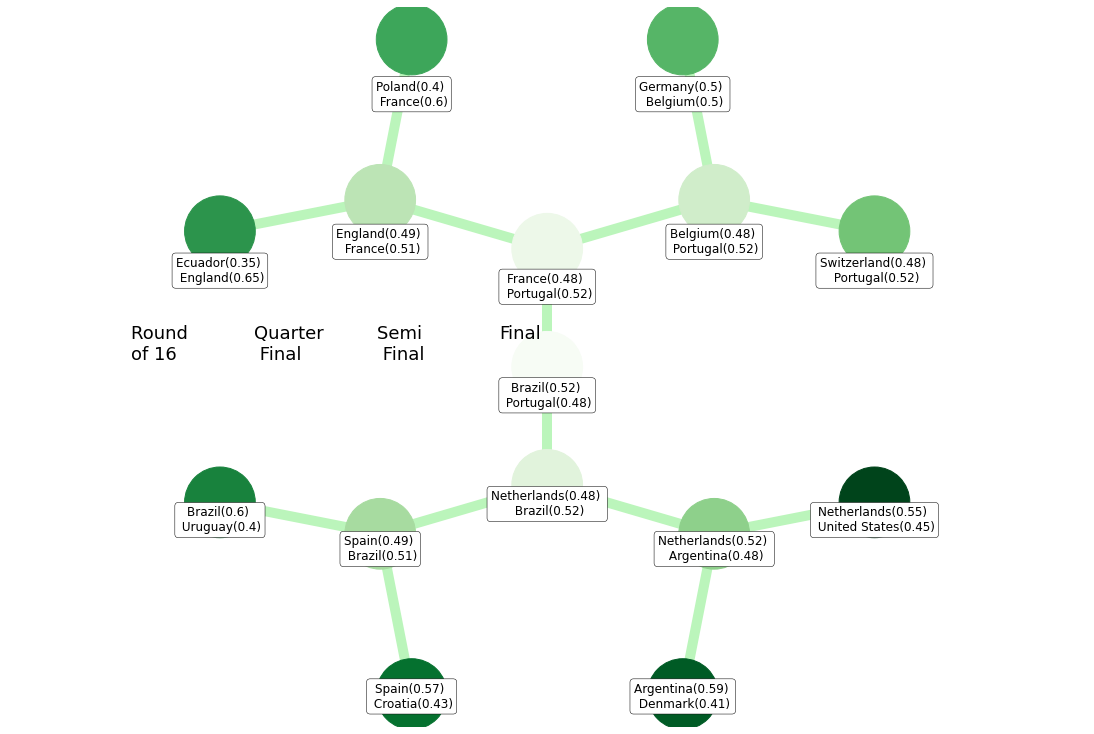

In [ ]:
plt.figure(figsize=(15, 10))
G = nx.balanced_tree(2, 3)


labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)
    
labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]

pos = graphviz_layout(G, prog='twopi')
labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()
    

nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=labels_dict)
texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 75 
    plt.text(pos_y, pos_x, text, fontsize = 18)

plt.axis('equal')
plt.show()

And that's the final simulation! Brazil has won the 6th title! Hoping that my predictions are correct now. 

It's nice to analyze too the possible upsets. Belgium passed against Germany, and were defeated by Portugal. Argentina - Netherlands game is very tight, with Netherlands passing by nearly 1%. The same happens between France and England, with England passing. I think England as finalist was the biggest upset of the simulation.

Update: the databases were updated with the last friendlies that national teams played before the World Cup, and, with that, some simulations changed. France now beats England at quarter-final, and they are defeated by Portugal in the semis! Portugal at the finals is a huge surprise! 

# Conclusion

The goal of this was to improve my knowledge with Machine Learning simulating something that I love (Football World Cup). I think that's amazing to create models that we can see the result in real life, and that's what is going to happen!

In general, I think that the model predicted like the common sense of people who watch football. There are not huge surprises in the simulation. It's also nice to see games with teams that are more unkown in group phase, like Iran vs. Wales or Senegal vs. Ecuador. I think that in games like that, the model is a good guidance to betting, since the knowledge of most people second tier national teams is not great.